In [1]:
# supress unnecessary warnings so the notebook looks clean
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import chisquare
pd.options.mode.chained_assignment = None 

# import plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.charts import Histogram, output_notebook, show
from bokeh.models import NumeralTickFormatter
output_notebook()

Loading BokehJS ...

In [2]:
act_train = pd.read_csv('datasets/act_train.csv',
                        dtype={'people_id': np.str,
                               'activity_id': np.str,
                               'otcome': np.int8},
                        parse_dates=['date'])
act_test = pd.read_csv('datasets/act_test.csv',
                        dtype={'people_id': np.str,
                               'activity_id': np.str,
                               'otcome': np.int8},
                        parse_dates=['date'])
people = pd.read_csv('datasets/people.csv',
                       dtype={'people_id': np.str,
                              'activity_id': np.str,
                              'char_38': np.int32},
                       parse_dates=['date'])

In [3]:
act_train.head(2)

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0


In [4]:
act_test.head(2)

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10
0,ppl_100004,act1_249281,2022-07-20,type 1,type 5,type 10,type 5,type 1,type 6,type 1,type 1,type 7,type 4,NaN
1,ppl_100004,act2_230855,2022-07-20,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 682


In [5]:
people.head(2)

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,...,False,True,True,False,False,True,True,True,False,36
1,ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,...,False,True,True,True,True,True,True,True,False,76


In [6]:
df_train = pd.merge(act_train, people, on='people_id')
df_test = pd.merge(act_test, people, on='people_id')

In [7]:
# identify target feature
target_feature = [x for x in df_train.columns.values if (x not in df_test.columns.values)]
print("Target feature in training data:", target_feature)

Target feature in training data: ['outcome']


In [8]:
# check missing values in training and testing data
print("Number of missing values in training data:", df_train.isnull().sum().sum())
print("-"*20)
print("Number of missing values in testing data:", df_test.isnull().sum().sum())

Number of missing values in training data: 18514699
--------------------
Number of missing values in testing data: 4167447


## Data Analysis

### 1. Feature Engineering

#### $\star$ people_id

In [9]:
# how many different people are active
print('Number of active people: {}'.format(act_train['people_id'].nunique()))

Number of active people: 151295


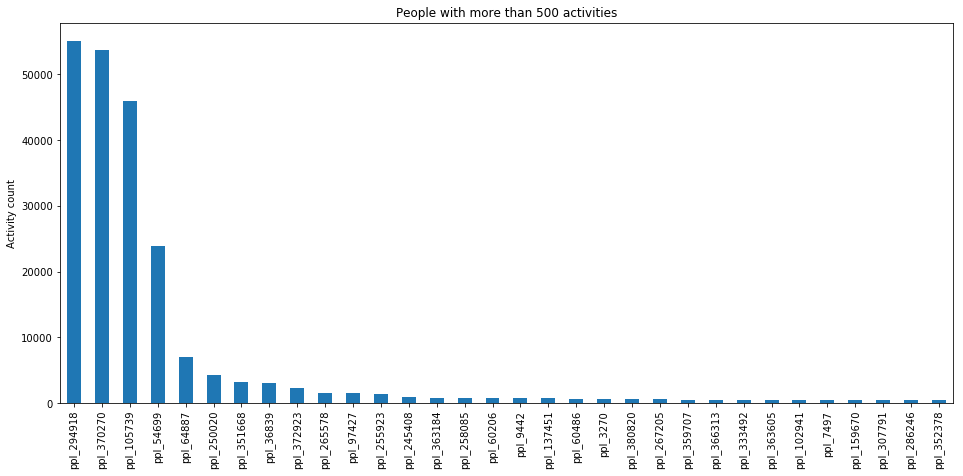

In [10]:
# which are the most active people, i.e., people with an activity count more than a given threshold
threshold = 500
people_counts = act_train['people_id'].value_counts()
people_counts[people_counts > threshold].plot(kind='bar')
plt.title('People with more than {} activities'.format(threshold))
plt.ylabel('Activity count')
fig = plt.gcf()
fig.set_size_inches(16, 7)

That's far from uniform. We can see that there are 4 very active people. Maybe these need special attention...

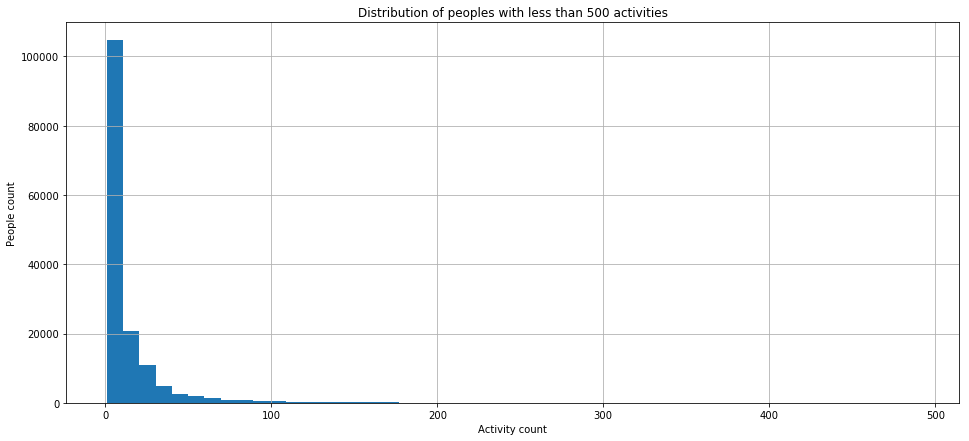

In [11]:
# how is the distribution of the less active people
people_counts[people_counts <= threshold].hist(bins=int(threshold / 10))
plt.xlabel('Activity count')
plt.ylabel('People count')
plt.title('Distribution of peoples with less than {} activities'.format(threshold))
fig = plt.gcf()
fig.set_size_inches(16, 7)

We see that the vast majority of the people (more than 100k out of the 151k) performed at most 10 activities.

#### $\star$  char_38

The only continuous value in the data is char_38 in the people table, and it's important.

- Failed outcomes have a mean of 28.17
- Successful outcomes have a mean of 77.30
- The distributions below are very telling

In [12]:
acts = act_train[['people_id', 'activity_id', 'outcome']]
peeps = people[['people_id', 'char_38']]

In [13]:
def string_to_int(series):
    series = series.fillna('type_0')
    series = series.apply(lambda x: x.split('_')[1])
    return series

acts.people_id = string_to_int(acts.people_id)
acts.activity_id = string_to_int(acts.activity_id)
peeps.people_id = string_to_int(peeps.people_id)

df = acts.merge(peeps, how='left', on='people_id')
df.head()

,people_id,activity_id,outcome,char_38
0,100,1734928,0,36
1,100,2434093,0,36
2,100,3404049,0,36
3,100,3651215,0,36
4,100,4109017,0,36


In [14]:
print("Total population distribution")
df.char_38.describe().round(2)

df_sample = df.sample(10000)
p = Histogram(df_sample, values='char_38', color='orange', bins=12, title="Total Sample Distribution")
p.yaxis[0].formatter = NumeralTickFormatter(format="0")
show(p)

Total population distribution


In [15]:
print("Failed 0 outcome")
df_fail = df[df.outcome == 0]
print(df_fail.char_38.describe().round(2))

df_fail = df_fail.sample(10000)
p = Histogram(df_fail, values='char_38', color='red', bins=12, title="Failed Outcome Distribution")
p.yaxis[0].formatter = NumeralTickFormatter(format="0")
show(p)

Failed 0 outcome
count    1221794.00
mean          28.17
std           32.02
min            0.00
25%            0.00
50%           14.00
75%           52.00
max          100.00
Name: char_38, dtype: float64


In [16]:
print("Successful 1 outcome")
df_success = df[df.outcome == 1]
print(df_success.char_38.describe().round(2))

df_success = df_success.sample(10000) 
p = Histogram(df_success, values='char_38', color='green', bins=12, title="Successful Outcome Distribution")
p.yaxis[0].formatter = NumeralTickFormatter(format="0")
show(p)

Successful 1 outcome
count    975497.00
mean         77.30
std          17.51
min           0.00
25%          67.00
50%          80.00
75%          91.00
max         100.00
Name: char_38, dtype: float64


The distribution has a zero-positive skew. Let's see how it looks with the zeros ignored.

In [17]:
df_sample_2 = df[df.char_38 > 0]
df_sample_2 = df_sample_2.sample(10000) 
p = Histogram(df_sample_2,values='char_38',color='outcome',title="Histogram of char_38 for outcomes",legend='top_right')
show(p)

In [18]:
del df_fail, df_success, df_sample, df_sample_2

#### $\star$ date

Let us check to see how dates of the train and test set are distributed. Are we predicting future values or a random sample?

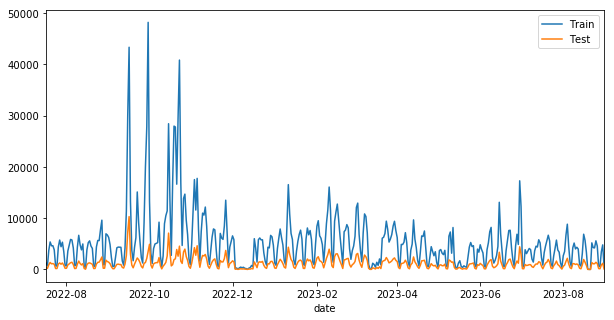

In [19]:
act_train['date'].groupby(act_train.date.dt.date).count().plot(figsize=(10,5), label='Train')
act_test['date'].groupby(act_test.date.dt.date).count().plot(figsize=(10,5), label='Test')
plt.legend()
plt.show()

This clearly shows that we are looking at a random distribution to test, rather than a time later in the future. Now check the distribution of the good and bad events.

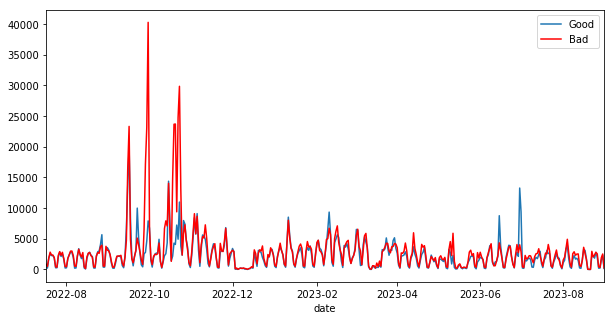

In [20]:
goods=act_train[act_train['outcome']==1]
bads=act_train[act_train['outcome']==0]
goods['date'].groupby(goods.date.dt.date).count().plot(figsize=(10,5),label='Good')
bads['date'].groupby(bads.date.dt.date).count().plot(figsize=(10,5),c='r',label='Bad')
plt.legend()
plt.show()

Most of the "bad" events are in the peak around Oct 2022! Finally, look to see if any people are better or worse bets on the return.

In [21]:
positive_counts=pd.DataFrame({'positive_counts' : act_train[act_train['outcome']==1] \
                              .groupby('people_id',as_index=True).size()}).reset_index()
negative_counts=pd.DataFrame({'negative_counts' : act_train[act_train['outcome']==0] \
                              .groupby('people_id',as_index=True).size()}).reset_index()

hstry=positive_counts.merge(negative_counts, on='people_id',how='outer')
hstry['positive_counts']=hstry['positive_counts'].fillna('0').astype(np.int64)
hstry['negative_counts']=hstry['negative_counts'].fillna('0').astype(np.int64)
hstry['profit']=hstry['positive_counts']-hstry['negative_counts']

In [22]:
hstry.sort_values(by='positive_counts',ascending=False).head(10)

,people_id,positive_counts,negative_counts,profit
62042,ppl_64887,7051,1,7050
68274,ppl_97427,1487,0,1487
61144,ppl_60206,736,0,736
67693,ppl_9442,730,0,730
49900,ppl_359707,556,0,556
51171,ppl_366313,555,0,555
530,ppl_102941,524,0,524
48447,ppl_352378,501,0,501
23505,ppl_22266,452,0,452
44764,ppl_333492,438,104,334


In [23]:
hstry.sort_values(by='negative_counts',ascending=False).head(10)

,people_id,positive_counts,negative_counts,profit
113762,ppl_294918,0,55103,-55103
51952,ppl_370270,12,53656,-53644
70163,ppl_105739,0,45936,-45936
141028,ppl_54699,0,23969,-23969
103401,ppl_250020,0,4293,-4293
126806,ppl_351668,0,3144,-3144
130693,ppl_36839,0,3059,-3059
131700,ppl_372923,0,2365,-2365
107006,ppl_265578,0,1539,-1539
104789,ppl_255923,0,1429,-1429


Now lets see if we can find a predictor (in the people descriptions) for who is a good investor and who is not.

- Note the there is no overlap in the 'people_id' between the training and test set
- As the 'profit' category has a wide range, we'll split it into very good (1), good(2), bad(3), very bad (4)

In [24]:
hstry['profit'].describe()

count    151295.000000
mean         -1.627926
std         241.334498
min      -55103.000000
25%          -5.000000
50%          -1.000000
75%           4.000000
max        7050.000000
Name: profit, dtype: float64

I'll break the categories roughly up into the quartiles.

- Profit of < -5 : 4
- -5 <= Profit <0: 3
- 0 <= Profit <= 5: 2
- 5 < Profit : 1

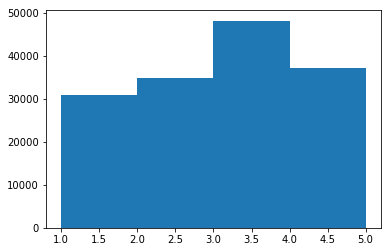

In [25]:
hstry['prof_label']=((pd.to_numeric(hstry['profit']<-5).astype(int) * 4 )+
                     (pd.to_numeric(hstry['profit'].isin(range(-5,1))).astype(int) * 3)+                     
                     (pd.to_numeric(hstry['profit'].isin(range(1,6))).astype(int) * 2)+
                     (pd.to_numeric(hstry['profit']>5).astype(int) * 1 ) )
plt.figure()
plt.hist(hstry['prof_label'],4,range=(1,5))
plt.show()

In [26]:
# make a new data frame which contains all of the people info and add to it the profit info
people_merged = pd.merge(people, hstry, on='people_id', how='inner')
people_merged['positive_counts']=people_merged['positive_counts'].fillna('0').astype(np.int64)
people_merged['negative_counts']=people_merged['negative_counts'].fillna('0').astype(np.int64)
people_merged['profit']=people_merged['profit'].fillna('0').astype(np.int64)

In [27]:
# turn all of the categorical data into integers

obs=['group_1']
for i in range (1,10):
    obs.append('char_'+str(i))
for x in obs:
    people_merged[x]=people_merged[x].fillna('type 0')
    people_merged[x]=people_merged[x].str.split(' ').str[1]

bools=[]
for i in range(10,38):
    bools.append('char_'+str(i))
for x in list(set(obs).union(set(bools))):
    people_merged[x]=pd.to_numeric(people_merged[x]).astype(int)
    
people_merged['date']=pd.to_numeric(people_merged['date']).astype(int)

In [28]:
## look through the boolean categories to see if there is any separation

#for x in bools:
#    plt.figure()
#    fig, ax= plt.subplots()
#    ax.set_xticks([1.5,2.5,3.5,4.5])
#    ax.set_xticklabels(('Very\nGood','Good','Bad','Very\nBad'))
#    fig.suptitle(x, fontsize=15)
#    neg=people_merged[people_merged[x]==0]
#    pos=people_merged[people_merged[x]==1]
#    plt.hist([pos['prof_label'],neg['prof_label']], 4,range=(1,5),
#              normed=True, stacked=True, label=['Has Trait','No Trait'])
#    plt.legend()
#    plt.show()

In [29]:
del hstry, people_merged

#### $\star$ Time Travel

First  let's take a look at the range of the two date variables.

In [30]:
for d in ['date_x', 'date_y']:
    print('Start of ' + d + ': ' + str(df_train[d].min().date()))
    print('  End of ' + d + ': ' + str(df_train[d].max().date()))
    print('  Range of ' + d + ': ' + str(df_train[d].max() - df_train[d].min()) + '\n')

Start of date_x: 2022-07-17
  End of date_x: 2023-08-31
  Range of date_x: 410 days 00:00:00

Start of date_y: 2020-05-18
  End of date_y: 2023-08-31
  Range of date_y: 1200 days 00:00:00



So we can see that all the dates are a few years in the future, all the way until 2023! Although we now though that this is because the data was anonymised, so we can essentially treat these as if they were the last few years instead.

We can also see that date_x is on the order of 1 year, while date_y is 3 times longer, even though they both end on the same day (the date before they stopped collecting the dataset perhaps?)

We'll go on more into looking at how the two features relate to each other later, but first let's look at the structure of the features separately.

Here I'm grouping the activities by date, and then for each date working out the number of activities that happened on that day as well as the probability of class 1 on that day.

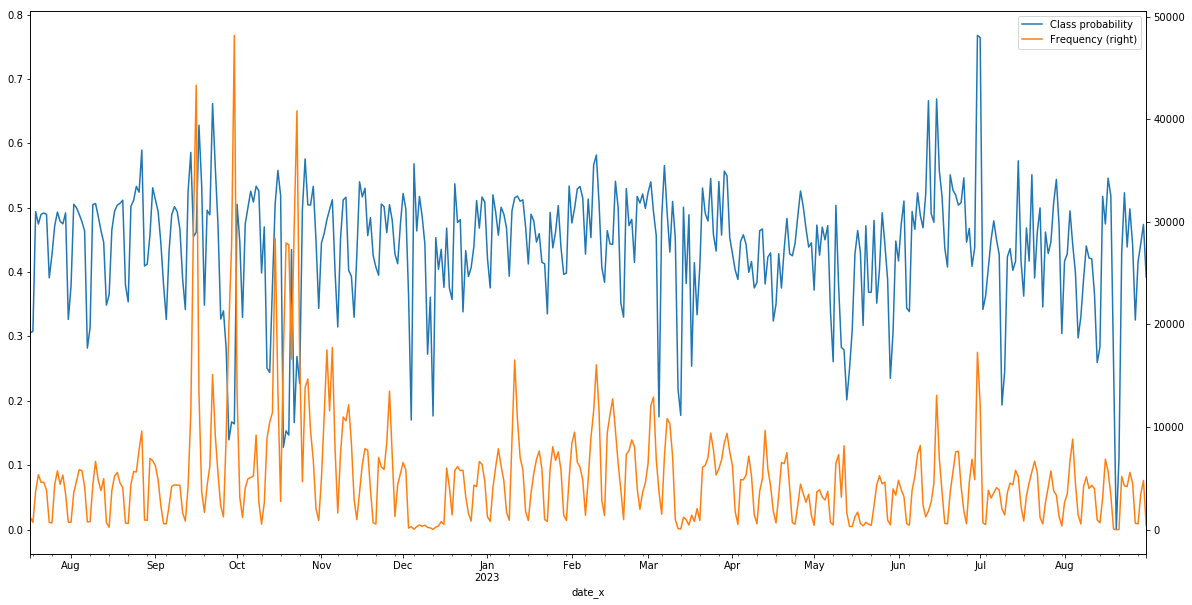

In [31]:
date_x = pd.DataFrame()
date_x['Class probability'] = df_train.groupby('date_x')['outcome'].mean()
date_x['Frequency'] = df_train.groupby('date_x')['outcome'].size()
date_x.plot(secondary_y='Frequency', figsize=(20, 10))

This plot shows some very interesting findings. There appears to be a very apparent weekly pattern, where on weekends there are much less events, as well as the probability of a event being a '1' class being much lower.

We can see that during the week the classes are pretty balanced at ~0.5 while on weekends they drop to 0.4-0.3 (this could be very useful information).

We can also see some very big peaks in number of activities around the September-October time frame, which we will look into later in the EDA. But first, let's do the same with the other date feature, date_y!

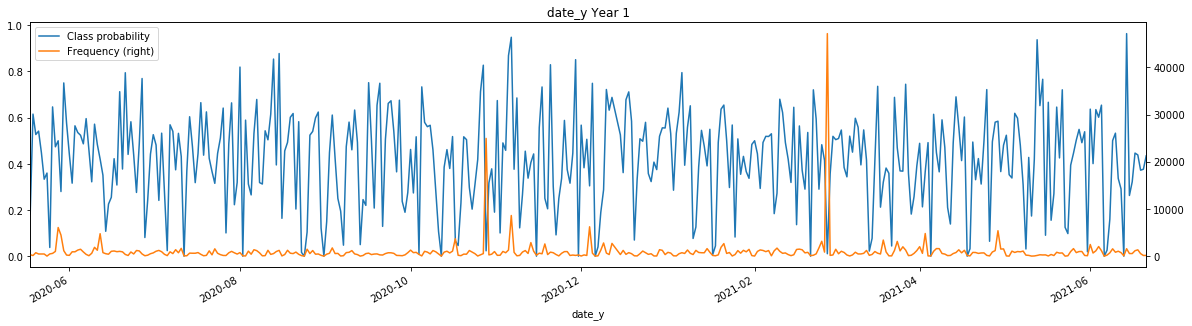

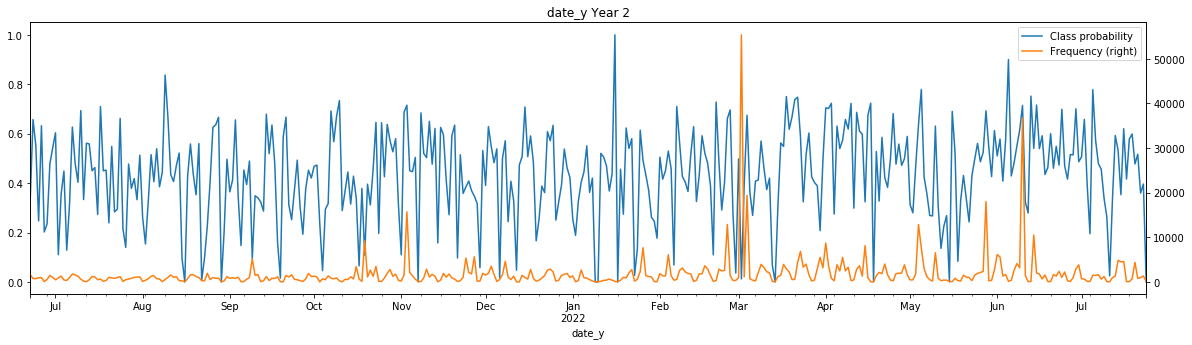

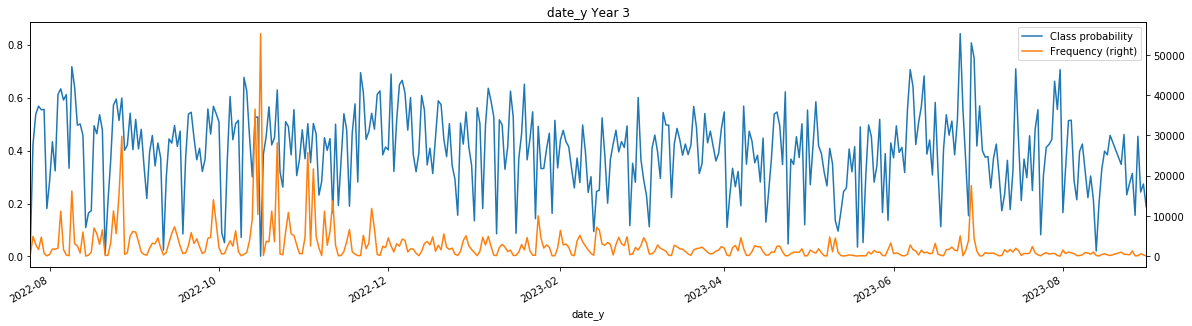

In [32]:
date_y = pd.DataFrame()
date_y['Class probability'] = df_train.groupby('date_y')['outcome'].mean()
date_y['Frequency'] = df_train.groupby('date_y')['outcome'].size()

# we need to split it into multiple graphs since the time-scale is too long to show well on one graph
i = int(len(date_y) / 3)
date_y[:i].plot(secondary_y='Frequency', figsize=(20, 5), title='date_y Year 1')
date_y[i:2*i].plot(secondary_y='Frequency', figsize=(20, 5), title='date_y Year 2')
date_y[2*i:].plot(secondary_y='Frequency', figsize=(20, 5), title='date_y Year 3')

There also appears to be a weekly structure to the date_y variable, although it isn't as cleanly visible. However, the class probabilities appear to swing much lower (reaching 0.2 on a weekly basis)

We have to take these class probabilities with a grain of salt however, since we are hitting very low numbers of samples in each day with the date_y (in the hundreds).

However, all of this information is useless if the same pattern doesn't emerge in the test set - let's find out if this is the case!

Since we don't know the true class values, we can't check if the same class probability appears in the test set, however we can check that the distribution of samples is the same.

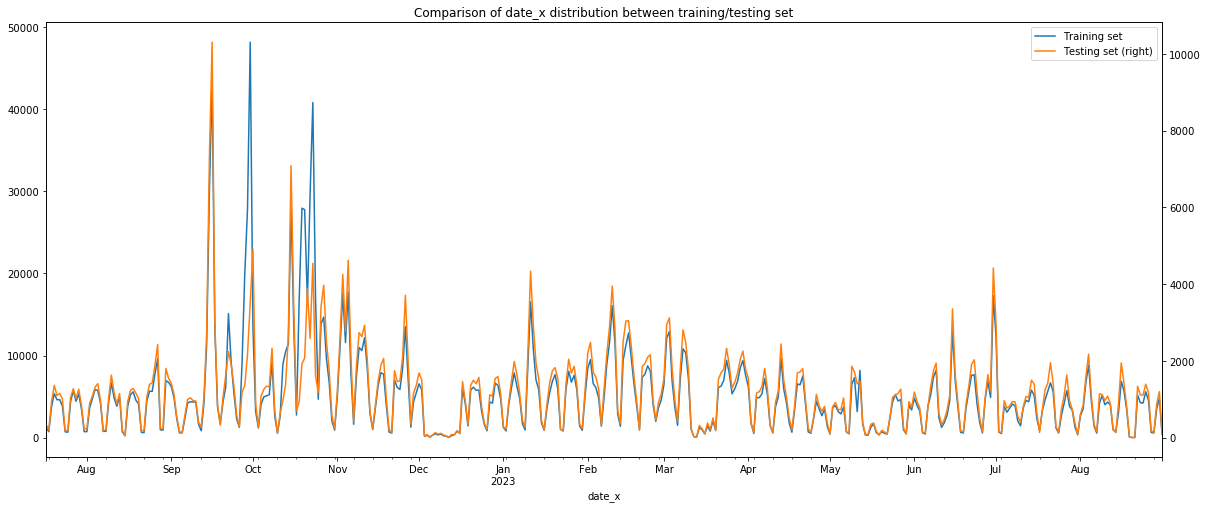

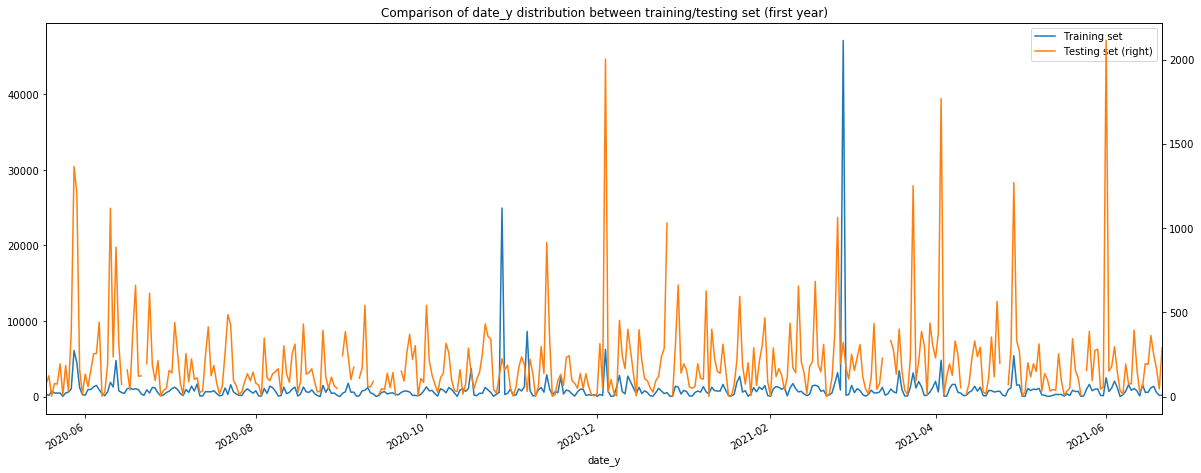

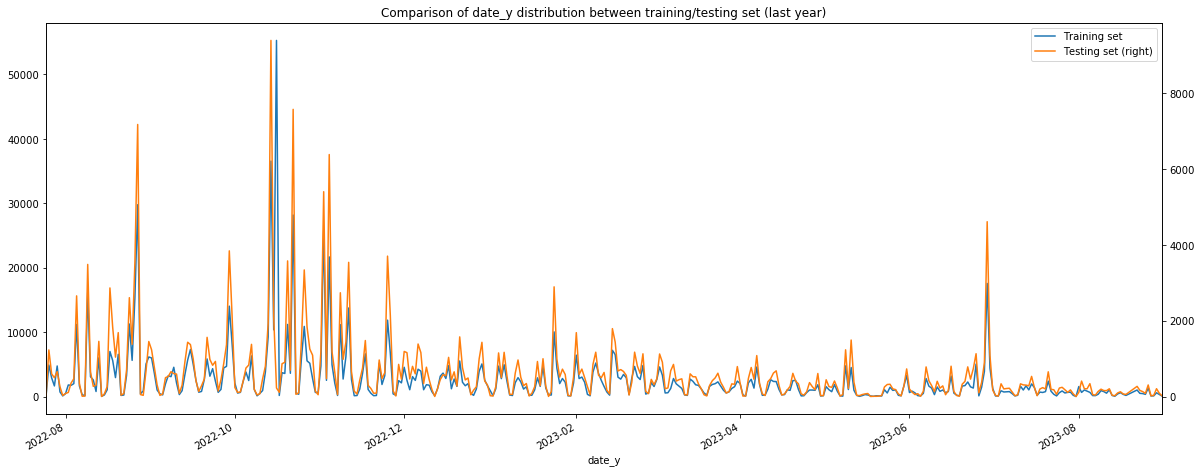

In [33]:
date_x_freq = pd.DataFrame()
date_x_freq['Training set'] = df_train.groupby('date_x')['activity_id'].count()
date_x_freq['Testing set'] = df_test.groupby('date_x')['activity_id'].count()
date_x_freq.plot(secondary_y='Testing set', figsize=(20, 8), 
                 title='Comparison of date_x distribution between training/testing set')

date_y_freq = pd.DataFrame()
date_y_freq['Training set'] = df_train.groupby('date_y')['activity_id'].count()
date_y_freq['Testing set'] = df_test.groupby('date_y')['activity_id'].count()
date_y_freq[:i].plot(secondary_y='Testing set', figsize=(20, 8), 
                 title='Comparison of date_y distribution between training/testing set (first year)')
date_y_freq[2*i:].plot(secondary_y='Testing set', figsize=(20, 8), 
                 title='Comparison of date_y distribution between training/testing set (last year)')

In [34]:
print('Correlation of date_x distribution in training/testing sets: ' \
      + str(np.corrcoef(date_x_freq.T)[0,1]))
print('Correlation of date_y distribution in training/testing sets: ' \
      + str(np.corrcoef(date_y_freq.fillna(0).T)[0,1]))

Correlation of date_x distribution in training/testing sets: 0.853430807691
Correlation of date_y distribution in training/testing sets: 0.709589035055


This gives us some interesting results. For date_x, we observe in the graph (and also in the high correlation value) that the training and testing sets have a very similar structure - this provides strong evidence that the training and testing sets are split based on people, and not based on time or some other unknown factor. Once again, we also observe the peaks (outliers?) in the September/October region.

However, the date_y is less clear cut. There is a low correlation between the two sets, although there is definitely some relationship that we can see visually. There appears to be very many spikes in the test set in the first year (what could this mean?) That being said, in the last year of date_y the relationship between the two sets is much more apparent. Let's try looking at the correlations over the years.

In [35]:
print('date_y correlation in year 1: ' + str(np.corrcoef(date_y_freq[:i].fillna(0).T)[0,1]))
print('date_y correlation in year 2: ' + str(np.corrcoef(date_y_freq[i:2*i].fillna(0).T)[0,1]))
print('date_y correlation in year 3: ' + str(np.corrcoef(date_y_freq[2*i:].fillna(0).T)[0,1]))

date_y correlation in year 1: 0.237056344324
date_y correlation in year 2: 0.682344221229
date_y correlation in year 3: 0.807207224857


Wow, that is definitely a huge improvement over time! Something about the structure of the first year of date_y doesn't match up, so we should keep that in mind (If anyone has any theories I would love to hear them).

To wrap up the first part of this EDA, I'm going to try turning the date class probabilities into features that we could use in our model, and then we can take a look at the AUCs that they give.

In [36]:
from sklearn.metrics import roc_auc_score

features = pd.DataFrame()
features['date_x_prob'] = df_train.groupby('date_x')['outcome'].transform('mean')
features['date_y_prob'] = df_train.groupby('date_y')['outcome'].transform('mean')
features['date_x_count'] = df_train.groupby('date_x')['outcome'].transform('count')
features['date_y_count'] = df_train.groupby('date_y')['outcome'].transform('count')

_=[print(f.ljust(12)+' AUC: '+str(round(roc_auc_score(df_train['outcome'],features[f]),6))) for f in features.columns]

date_x_prob  AUC: 0.626182
date_y_prob  AUC: 0.720296
date_x_count AUC: 0.465697
date_y_count AUC: 0.475916


It looks like the date probability features have very high predictive power! I think we might be onto something here.

Anyway, that's all I've got for now. I'll be back with more graphs and text soon, in the meantime if anyone has any theories or questions feel free to ask/discuss in the comments.

In [37]:
del date_x, date_y, date_x_freq, date_y_freq, features

### 2. Decomposition Techniques

Let's see if it makes sense to use any decomposition techniques. I think there could be a couple good reasons why we might want to do this:

- If a lot of the characteristics of people are interdependent variables, we can consolidate them into single features so as to not muddy our final classifier inputs with repeat information.
- There's potential for discovering latent features that are only evident by looking at multiple features together.
- If you're like me, you might be pretty limited on computing resources and want to shrink the people data set before merging it in.

Since it looks like all the characteristics are denoted with a "char_" prefix. Let's use that to make sure that we don't drag along extra columns. Then we'll run a matrix of chi squared tests to get an idea of which features might be interdependent.

In [38]:
from scipy.stats import chisquare

# create a list of characteristics
chars = [i for i in people.columns.values if "char_" in i]

# create an empty list for appending flagged features
flags = []

# for each feature summarize frequencies of each other feature
for feat in people[chars]:
    group = people[chars].groupby(feat)
    for otherfeat in people[chars].drop(feat, axis=1):
        summary = group[otherfeat].count()
        # run a chi squared test on the frequencies, and check if the p-value is less than 0.05
        if chisquare(summary)[1] < 0.05:         
            # if so, flag both features
            flags.append(feat)
            flags.append(otherfeat)

# Rremove duplicates by converting to a set at the end
flags = set(flags)

print("It looks like {}% of the characteristics might be related to one another." \
      .format(len(flags)/len(chars)*100))

It looks like 100.0% of the characteristics might be related to one another.


Wow, 100%. Hopefully someone reviewing this can highlight if I implemented those tests wrong, or if chi squared wasn't the right test of choice. At any rate, I'm going to proceed on the assumption that we should definitely be using some decomposition techniques on the data set, if only just to reduce the repeated information. Let's use the scikit-learn implementation of PCA. Some success with PCA would confirm that the chi squared tests were useful.

In [39]:
# convert to dummy variables
dums = pd.get_dummies(people[chars])
print("Before PCA the full size of the characteristics is {} features".format(len(dums.columns.values)))

Before PCA the full size of the characteristics is 160 features


In [40]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# let's scale the features so that they're all in the range of 0 and 1
scaledums = MinMaxScaler().fit_transform(dums)

# now let's just look at the first two principle components first
pca = PCA(n_components=2)
featurecomponents = pca.fit_transform(scaledums)

print(pca.explained_variance_ratio_)

[ 0.35559326  0.06815741]


Awesome, scaling seems to fix the problem of char_38 dominating the first component and the overall variance of the dataset.

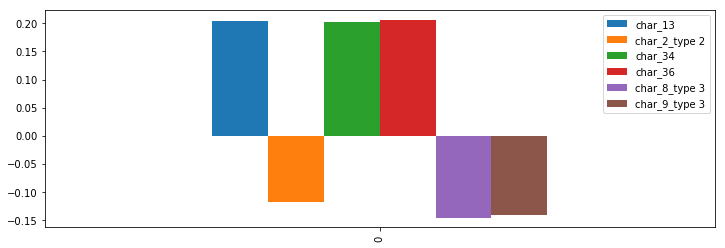

In [41]:
# build a dictionary with the names of the components
components = {}
index = 0
for feature in dums.columns.values:
    components[feature] = [pca.components_[0][index]]
    index += 1
    
# exclude all but the most extreme components, because there are a lot
sortedcomps = pca.components_[0]
sortedcomps.sort()
maxcap = sortedcomps[-3]
mincap = sortedcomps[2]
components = {i:x for i, x in components.items() if x >= maxcap or x <= mincap}
    
# convert to dataframe
components = pd.DataFrame(components)

# plot the most extreme components
components.plot(kind="bar", figsize=(12, 4))

Interesting, and plotting the most extreme contributors to the first principle component, char_38 isn't among them. So scaling down char_38 was really critical.

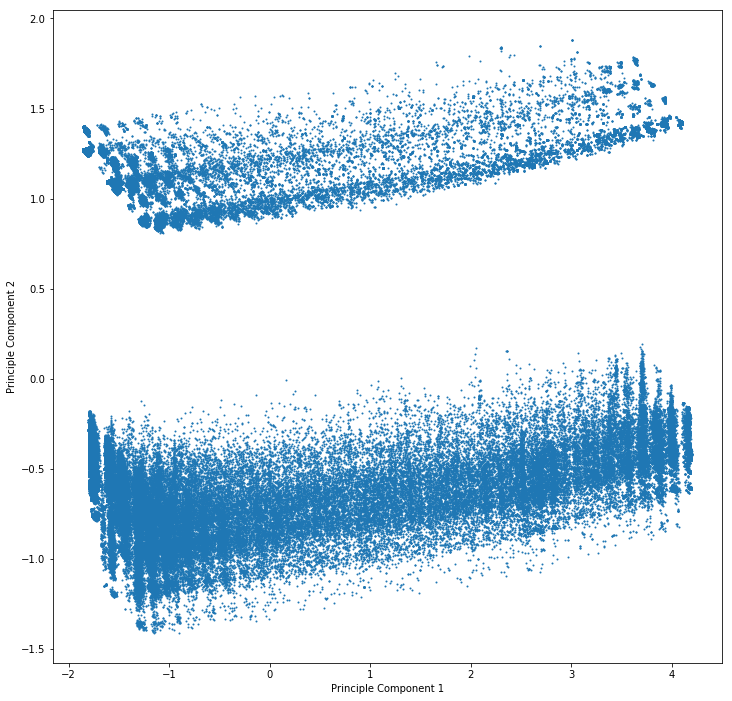

In [42]:
# plot the first two principle components
featurecomponents = pd.DataFrame(featurecomponents, columns=["Principle Component 1", "Principle Component 2"])
df["Principle Component 1"] = featurecomponents["Principle Component 1"]
featurecomponents.plot(kind="scatter",x="Principle Component 1",y="Principle Component 2",figsize=(12, 12), s=1)

I'm curious now what the group_1 feature looks in terms of these first two principle components. I wonder if the groups were made from the characteristics, or something else. Just for curiosity's sake, let's plot a few groups.

There are 1 data points in this group.


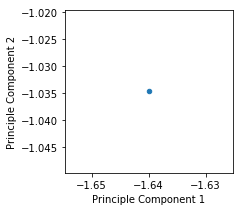

In [43]:
# add group_1 to the new data from pca
featurecomponents["group_1"] = people["group_1"]

# get a list of groups to sample from
groupslist = list(set(featurecomponents["group_1"].tolist()))

# pick a group and plot
group = featurecomponents[featurecomponents["group_1"]==groupslist[0]]
group.plot(kind="scatter", x="Principle Component 1", y="Principle Component 2", figsize=(3, 3))
print("There are {} data points in this group.".format(len(group.index)))

There are 10 data points in this group.


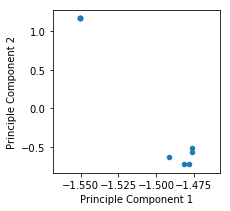

In [44]:
# pick a group and plot
group = featurecomponents[featurecomponents["group_1"]==groupslist[5]]
group.plot(kind="scatter", x="Principle Component 1", y="Principle Component 2", figsize=(3, 3))
print("There are {} data points in this group.".format(len(group.index)))

There are 1 data points in this group.


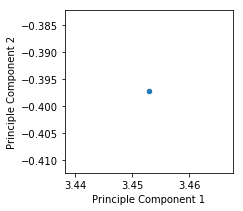

In [45]:
# pick a group and plot
group = featurecomponents[featurecomponents["group_1"]==groupslist[6]]
group.plot(kind="scatter", x="Principle Component 1", y="Principle Component 2", figsize=(3, 3))
print("There are {} data points in this group.".format(len(group.index)))

Plotting the a few groups with at least two data points to them, I can't really tell if group_1 was created from clustering the characteristics. However, these first two principle components don't capture all of the information from the characteristics, and browsing through six data points is hardly conclusive. I or someone else will have to explore this more thoroughly.

As a final question, how many principle components do I need to merge into the train/test sets if I only care about a certain amount of the explained variance?

In [46]:
# define a list of possible amounts of explained variance we might care about
cares = [i/100 for i in range(80, 100, 10)]

# run the PCA with increased components until each care level is reached
for i in range (20, len(dums.columns.values)):
    pca = PCA(n_components=i)
    pca.fit(scaledums)
    
    try:
        if pca.explained_variance_ratio_.sum() > cares[0]:

            # if greater, print a statement and drop the first item off the list
            print("To explain {0} of the variance you'll need {1} components".format(cares[0], i))
            cares = cares[1:]
    except:
        break

To explain 0.8 of the variance you'll need 28 components
To explain 0.9 of the variance you'll need 50 components


## Model Building

In [47]:
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder

In [48]:
act_train=act_train.drop('char_10',axis=1)
act_test=act_test.drop('char_10',axis=1)

print("Train data shape: " + format(act_train.shape))
print("Test data shape: " + format(act_test.shape))
print("People data shape: " + format(people.shape))

Train data shape: (2197291, 14)
Test data shape: (498687, 13)
People data shape: (189118, 41)


In [49]:
def act_data_treatment(dsname):
    dataset = dsname
    
    for col in list(dataset.columns):
        if col not in ['people_id', 'activity_id', 'date', 'char_38', 'outcome']:
            if dataset[col].dtype == 'object':
                dataset[col].fillna('type 0', inplace=True)
                dataset[col] = dataset[col].apply(lambda x: x.split(' ')[1]).astype(np.int32)
            elif dataset[col].dtype == 'bool':
                dataset[col] = dataset[col].astype(np.int8)
    
    dataset['year'] = dataset['date'].dt.year
    dataset['month'] = dataset['date'].dt.month
    dataset['day'] = dataset['date'].dt.day
    dataset['isweekend'] = (dataset['date'].dt.weekday >= 5).astype(int)
    dataset = dataset.drop('date', axis = 1)
    
    return dataset

act_train  = act_data_treatment(act_train)
act_test   = act_data_treatment(act_test)
people     = act_data_treatment(people)

In [50]:
df_train = act_train.merge(people, on='people_id', how='left', left_index=True)
df_test  = act_test.merge(people, on='people_id', how='left', left_index=True)

df_train = df_train.sort_values(['people_id'], ascending=[1])
df_test  = df_test.sort_values(['people_id'], ascending=[1])

df_train.fillna('NA', inplace=True)
df_test.fillna('NA', inplace=True)

In [51]:
y = df_train.outcome
df_train=df_train.drop('outcome',axis=1)

In [52]:
df_train_columns = df_train.columns.values
df_test_columns = df_test.columns.values
features = list(set(df_train_columns) & set(df_test_columns))

In [53]:
def reduce_dimen(dataset,column,toreplace):
    for index,i in dataset[column].duplicated(keep=False).iteritems():
        if i==False:
            dataset.set_value(index,column,toreplace)
    return dataset

whole=pd.concat([df_train,df_test],ignore_index=True)

In [54]:
categorical=['group_1','activity_category','char_1_x','char_2_x','char_3_x','char_4_x','char_5_x',
             'char_6_x','char_7_x','char_8_x','char_9_x','char_2_y','char_3_y','char_4_y','char_5_y',
             'char_6_y','char_7_y','char_8_y','char_9_y']

for category in categorical:
    whole=reduce_dimen(whole,category,9999999)

X = whole[:len(df_train)]
X = X.sort_values(['people_id'], ascending=[1])
X = X[features].drop(['people_id', 'activity_id'], axis = 1)
                            
X_test = whole[len(df_train):]
X_test = X_test[features].drop(['people_id', 'activity_id'], axis = 1)

In [55]:
categorical=['group_1','activity_category','char_1_x','char_2_x','char_3_x','char_4_x','char_5_x',
             'char_6_x','char_7_x','char_8_x','char_9_x','char_2_y','char_3_y','char_4_y','char_5_y',
             'char_6_y','char_7_y','char_8_y','char_9_y']

not_categorical=[]
for category in X.columns:
    if category not in categorical:
        not_categorical.append(category)

In [56]:
from scipy.sparse import hstack

enc = OneHotEncoder(handle_unknown='ignore')
enc = enc.fit(pd.concat([X[categorical],X_test[categorical]]))

X_cat_sparse = enc.transform(X[categorical])
X_test_cat_sparse = enc.transform(X_test[categorical])

X_sparse=hstack((X[not_categorical], X_cat_sparse))
X_test_sparse=hstack((X_test[not_categorical], X_test_cat_sparse))

print("Training data: " + format(X_sparse.shape))
print("Test data: " + format(X_test_sparse.shape))
print("One Hot enconded Test Dataset Script")

Training data: (2197291, 31271)
Test data: (498687, 31271)
One Hot enconded Test Dataset Script


In [57]:
dtrain = xgb.DMatrix(X_sparse,label=y)
dtest = xgb.DMatrix(X_test_sparse)

param = {'max_depth':5, 'eta':0.02, 'silent':1, 'objective':'binary:logistic' }
param['nthread'] = 4
param['eval_metric'] = 'auc'
param['subsample'] = 0.7
param['colsample_bytree']= 0.7
param['min_child_weight'] = 0
param['booster'] = "gblinear"

watchlist  = [(dtrain,'train')]
num_round = 300
early_stopping_rounds=10

In [58]:
bst = xgb.train(param, dtrain, num_round, watchlist,early_stopping_rounds=early_stopping_rounds)
ypred = bst.predict(dtest)

[0]	train-auc:0.886275
Will train until train-auc hasn't improved in 10 rounds.
[1]	train-auc:0.894374
[2]	train-auc:0.902687
[3]	train-auc:0.911203
[4]	train-auc:0.919634
[5]	train-auc:0.927681
[6]	train-auc:0.935103
[7]	train-auc:0.941911
[8]	train-auc:0.948226
[9]	train-auc:0.95408
[10]	train-auc:0.959452
[11]	train-auc:0.96431
[12]	train-auc:0.968619
[13]	train-auc:0.972378
[14]	train-auc:0.975595
[15]	train-auc:0.978336
[16]	train-auc:0.980653
[17]	train-auc:0.982597
[18]	train-auc:0.984221
[19]	train-auc:0.985578
[20]	train-auc:0.986713
[21]	train-auc:0.987672
[22]	train-auc:0.988486
[23]	train-auc:0.989186
[24]	train-auc:0.989793
[25]	train-auc:0.990327
[26]	train-auc:0.990801
[27]	train-auc:0.991226
[28]	train-auc:0.991608
[29]	train-auc:0.991955
[30]	train-auc:0.992271
[31]	train-auc:0.99256
[32]	train-auc:0.992826
[33]	train-auc:0.99307
[34]	train-auc:0.993296
[35]	train-auc:0.993504
[36]	train-auc:0.993698
[37]	train-auc:0.993878
[38]	train-auc:0.994046
[39]	train-auc:0.9942

array([ 0.00152744,  0.00163272,  0.99950051,  0.9994967 ,  0.9994899 ], dtype=float32)

In [59]:
ypred[:5]

array([ 0.00152744,  0.00163272,  0.99950051,  0.9994967 ,  0.9994899 ], dtype=float32)